In [1]:
# Author: Vu-Duc Tran
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA


In [2]:
def test_stationarity(timeseries, p=0.05):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
    
    if dftest[1] > p:
        return 0
    else:
        return 1

def take_log_ts(ts):
    ts_log = np.log(ts)
    plt.figure(1)
    plt.subplot(211)
    plt.plot(ts)
    plt.subplot(212)
    plt.plot(ts_log)
    return ts_log

def MA_diff(timeseries, periods=12):
    # Difference from MA 
    moving_avg = timeseries.rolling(periods).mean()
    ts_moving_avg_diff = timeseries - moving_avg
    ts_moving_avg_diff.dropna(inplace=True)
    return moving_avg, ts_moving_avg_diff

def expweighted_diff(timeseries, halflife=12):
    expwighted = timeseries.ewm(halflife)
    expwighted_avg = expwighted.mean()
    ts_expwighted_avg_diff = timeseries - expwighted_avg
    return expwighted_avg, ts_expwighted_avg_diff

def take_diff(ts, order=1, periods=1):
    if order != 0:
        for i in range(order):
            ts = ts - ts.shift(periods=periods)
    ts.dropna(inplace=True)
    return ts

def decomposition_diff(timeseries):   
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    
    ts_decompose = residual
    ts_decompose.dropna(inplace=True)
    adftest = test_stationarity(ts_decompose)
    return trend, seasonal, residual, adftest

def acf_pacf(timeseries, nlags=20):
    lag_acf = acf(timeseries, nlags=nlags)
    lag_pacf = pacf(timeseries, nlags=nlags, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.bar(range(len(lag_acf)), lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    #Plot PACF:
    plt.subplot(122)
    plt.bar(range(len(lag_pacf)), lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
    return lag_acf, lag_pacf

def build_ARIMA(ts, order=(1,0,1)):
    p,d,q = order
    ts_diff = take_diff(ts, order=d)
    model = ARIMA(ts, order=order)
    results = model.fit(disp=-1)
    RSS = sum((results.fittedvalues-ts_diff)**2)
    plt.plot(ts_diff)
    plt.plot(results.fittedvalues, color='red')
    plt.title('ARIMA(%d,%d,%d) - RSS: %.4f'% (p,d,q,sum((results.fittedvalues-ts_log_diff)**2)))
    return results, RSS

def take_back_diff(ts_diff, inivalue, index, order=1, periods=1):
    pd_ts_diff = pd.Series(ts_diff, copy=True)
    pd_ts_diff_cumsum = pd_ts_diff.cumsum()
    original_ts = pd.Series(inivalue, index=index)
    original_ts = original_ts.add(pd_ts_diff_cumsum, fill_value=0)
    return original_ts

def take_back_exp(ts_log):
    ts = np.exp(ts_log)
    return ts

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('data/bbts/AirPassengers.csv', parse_dates=['Month'], 
                   index_col='Month', date_parser=dateparse)
print data.head()

            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121


In [4]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name=u'Month', length=144, freq=None)

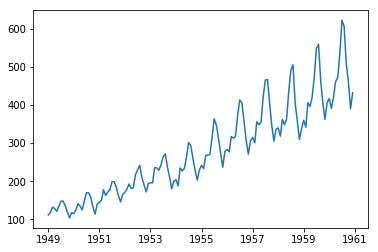

In [5]:
ts = data['#Passengers']
plt.plot(ts)

In [6]:
# #1. Specific the index as a string constant:
# ts['1949-01-01']
# #2. Import the datetime library and use 'datetime' function:
# ts[datetime(1949,1,1)]
# ts['1949']

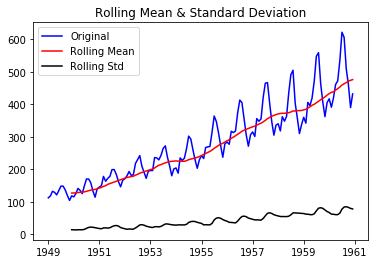

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [7]:
t = test_stationarity(ts)

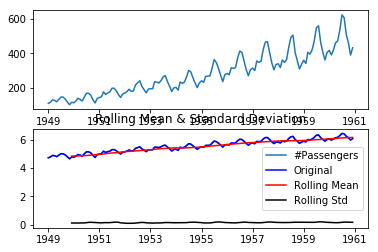

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
# Taking log of time series
ts_log = take_log_ts(ts)
adftest = test_stationarity(ts_log)

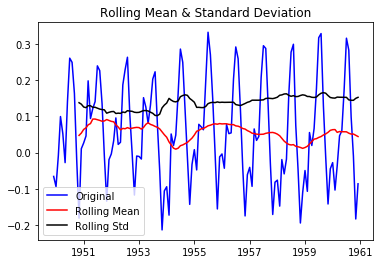

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [9]:
# Eliminate trend by Moving-Average
moving_avg, ts_log_moving_avg_diff = MA_diff(ts_log)
adftest = test_stationarity(ts_log_moving_avg_diff)


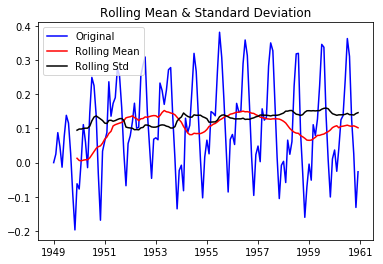

Results of Dickey-Fuller Test:
Test Statistic                  -3.566092
p-value                          0.006443
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
# Eliminate trend by Exponential_Weighted_Moving-Average
expwighted_avg, ts_expwighted_avg_diff = expweighted_diff(ts_log)
adftest = test_stationarity(ts_expwighted_avg_diff)

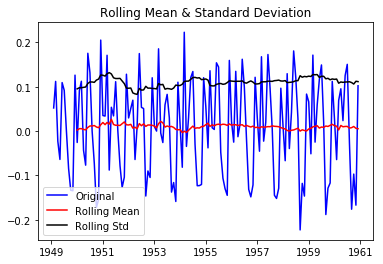

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [12]:
# Eliminate trend and seasonal components by differencing
order=1
periods=1
ts_log_diff = take_diff(ts_log, order=order, periods=periods)
adftest = test_stationarity(ts_log_diff)

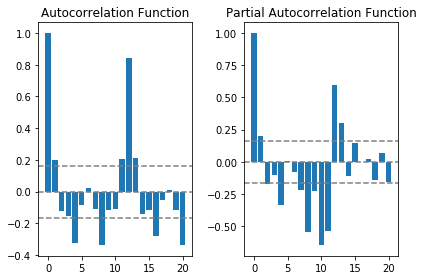

In [13]:
# View ACF-PACF
lag_acf, lag_pacf = acf_pacf(ts_log_diff)

/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


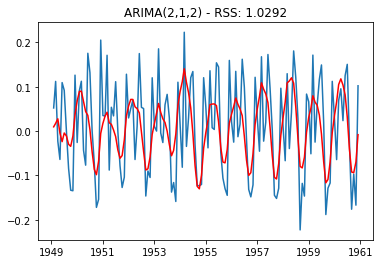

In [14]:
# Estimate ARIMA Model
model, RSS = build_ARIMA(ts_log, order=(2,1,2))

In [15]:
# Compare models
model.aic, model.bic

(-287.2808079212986, -269.5037401397392)

(array([ 1.        ,  0.00755254, -0.19245871, -0.0381831 , -0.19184965,
         0.12580119,  0.25274721,  0.05384056, -0.29185978, -0.10133715,
        -0.30231063, -0.09708251,  0.68830102, -0.05254845, -0.31483156,
        -0.09181736, -0.22084841,  0.12184464,  0.23261339,  0.08533699,
        -0.23546351]),
 array([ 1.        ,  0.00761013, -0.19673556, -0.03460634, -0.24666973,
         0.13324715,  0.18357907,  0.10906545, -0.31229922, -0.0268807 ,
        -0.45834195, -0.20244133,  0.6696778 , -0.06081428, -0.48290599,
        -0.14900767, -0.19689212, -0.03563559, -0.03622528,  0.26456169,
         0.06952041]))

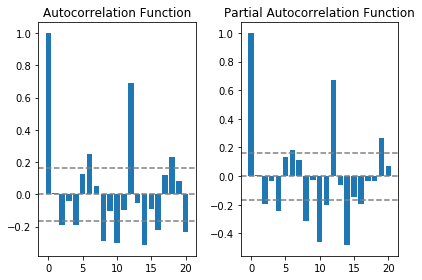

In [16]:
# Residual analysis
acf_pacf(model.resid)

Text(0.5,1,'RMSE: 90.1050')

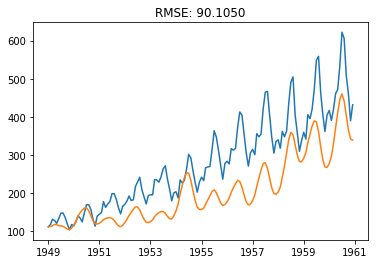

In [17]:
# Model Fitting
predictions_ts_log = take_back_diff(model.fittedvalues, ts_log.iloc[0], ts_log.index)
predictions_ARIMA = take_back_exp(predictions_ts_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

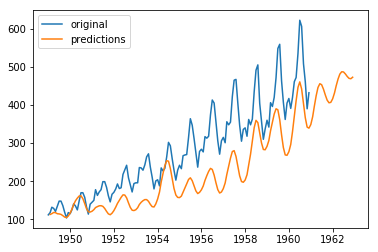

In [18]:
# Forecast
end_date = '1962-12-01'
predictions = model.predict(end=end_date)
num_forecast = len(predictions)-len(ts_log)+1
predictions_ts_log = take_back_diff(predictions, ts_log.iloc[0], predictions.index)
predictions_ARIMA = take_back_exp(predictions_ts_log)
plt.plot(ts, label='original')
plt.plot(predictions_ARIMA, label='predictions')
plt.legend()